In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from reco.matching import get_highest_energy_fraction_simtracksters
from reco.features import longest_path_from_highest_centrality, mean_edge_length, mean_edge_energy_gap


ds_name = "CloseByTwoPion"
file_name = "new_ntuples_15101852_0.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"

tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})

In [2]:
cx = tracksters["vertices_x"].array()
cy = tracksters["vertices_y"].array()
cz = tracksters["vertices_z"].array()
ce = tracksters["vertices_energy"].array()
ci = tracksters["vertices_indexes"].array()

sx = simtracksters["stsSC_vertices_x"].array()
sy = simtracksters["stsSC_vertices_y"].array()
sz = simtracksters["stsSC_vertices_z"].array()
se = simtracksters["stsSC_vertices_energy"].array()
si = simtracksters["stsSC_vertices_indexes"].array()

## Number of vertices and total energy

In [3]:
nvertices = []
tenergy = []
fracs = []
t_frac = []

for e in range(len(cx)):
    te = ce[e]  # get event
    reco_fr, reco_st = get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, e)

    for tx in range(len(te)):   
        ve = te[tx]         # get trackster
        fr = reco_fr[tx]
        nvertices.append(len(ve))
        tenergy.append(sum(ve))
        fracs.append(fr)

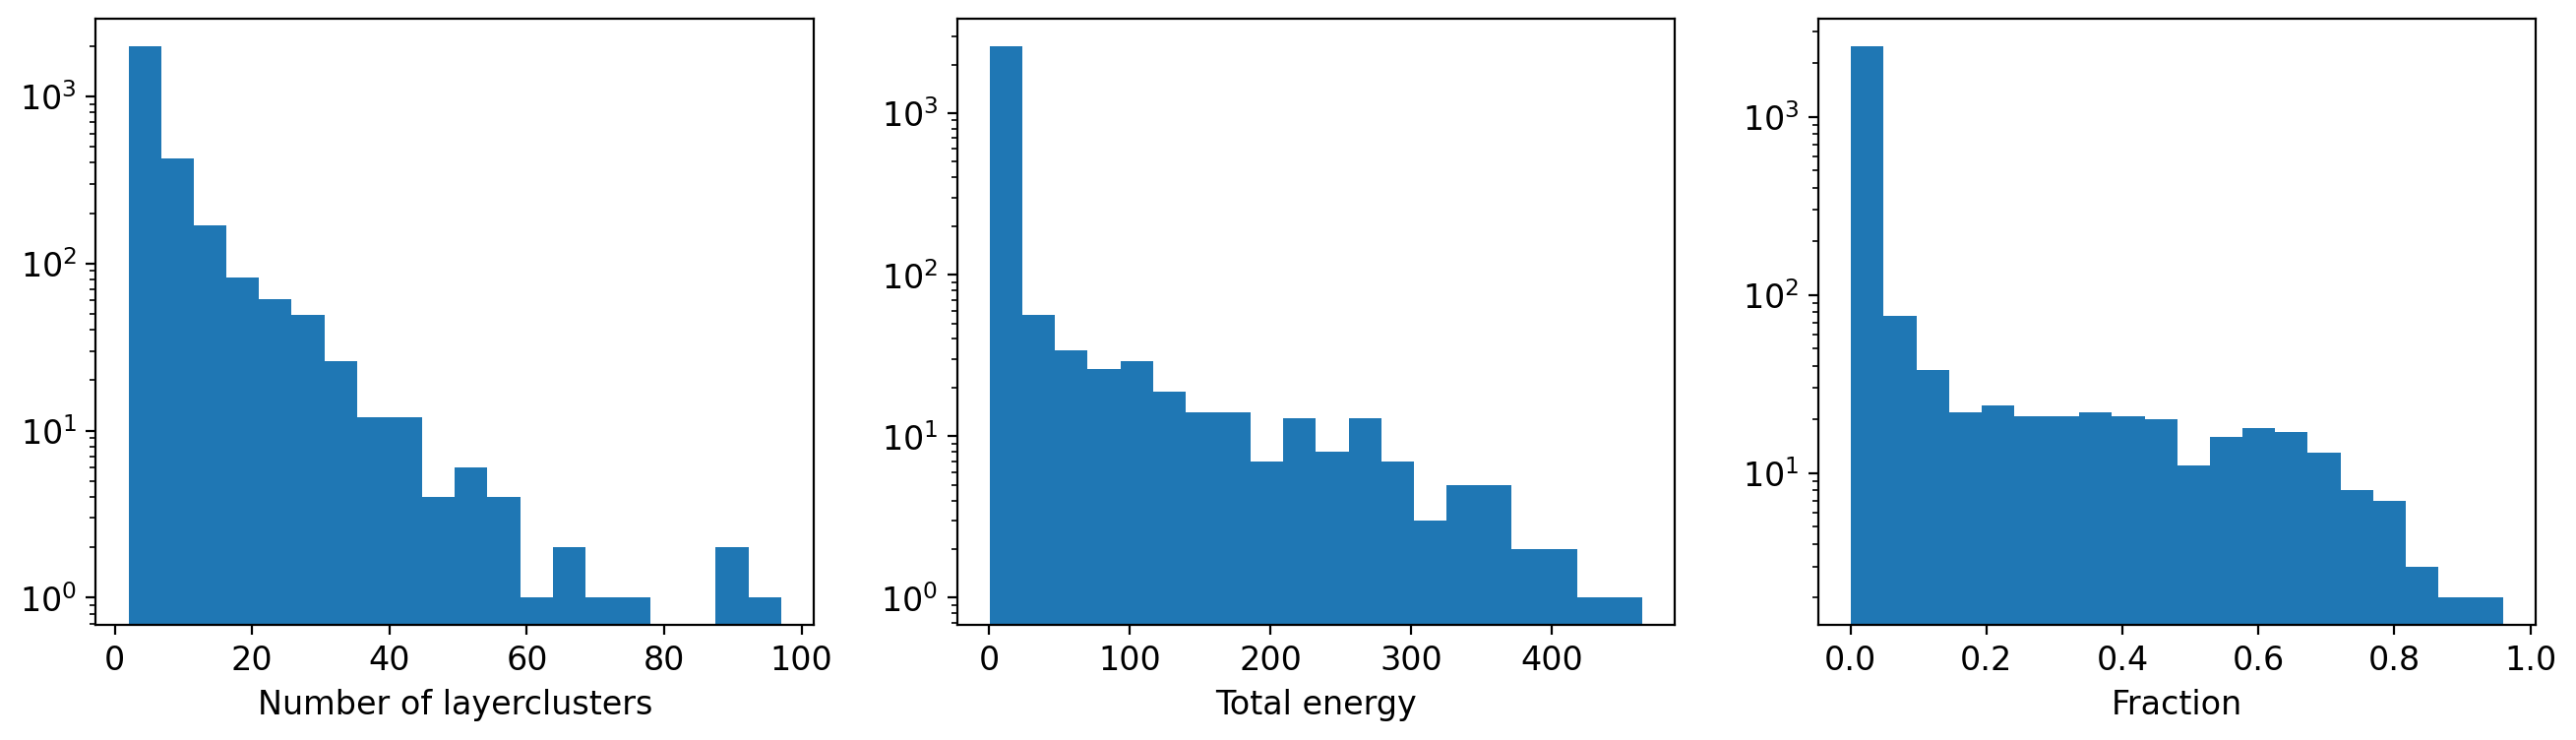

In [4]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(131)
ax.hist(nvertices, bins=20)
ax.set_yscale("log")
ax.set_xlabel("Number of layerclusters")

ax = fig.add_subplot(132)
ax.set_xlabel("Total energy")
ax.hist(tenergy, bins=20)
ax.set_yscale("log")

ax = fig.add_subplot(133)
ax.set_xlabel("Fraction")
ax.set_yscale("log")
ax.hist(fracs, bins=20)

plt.show()

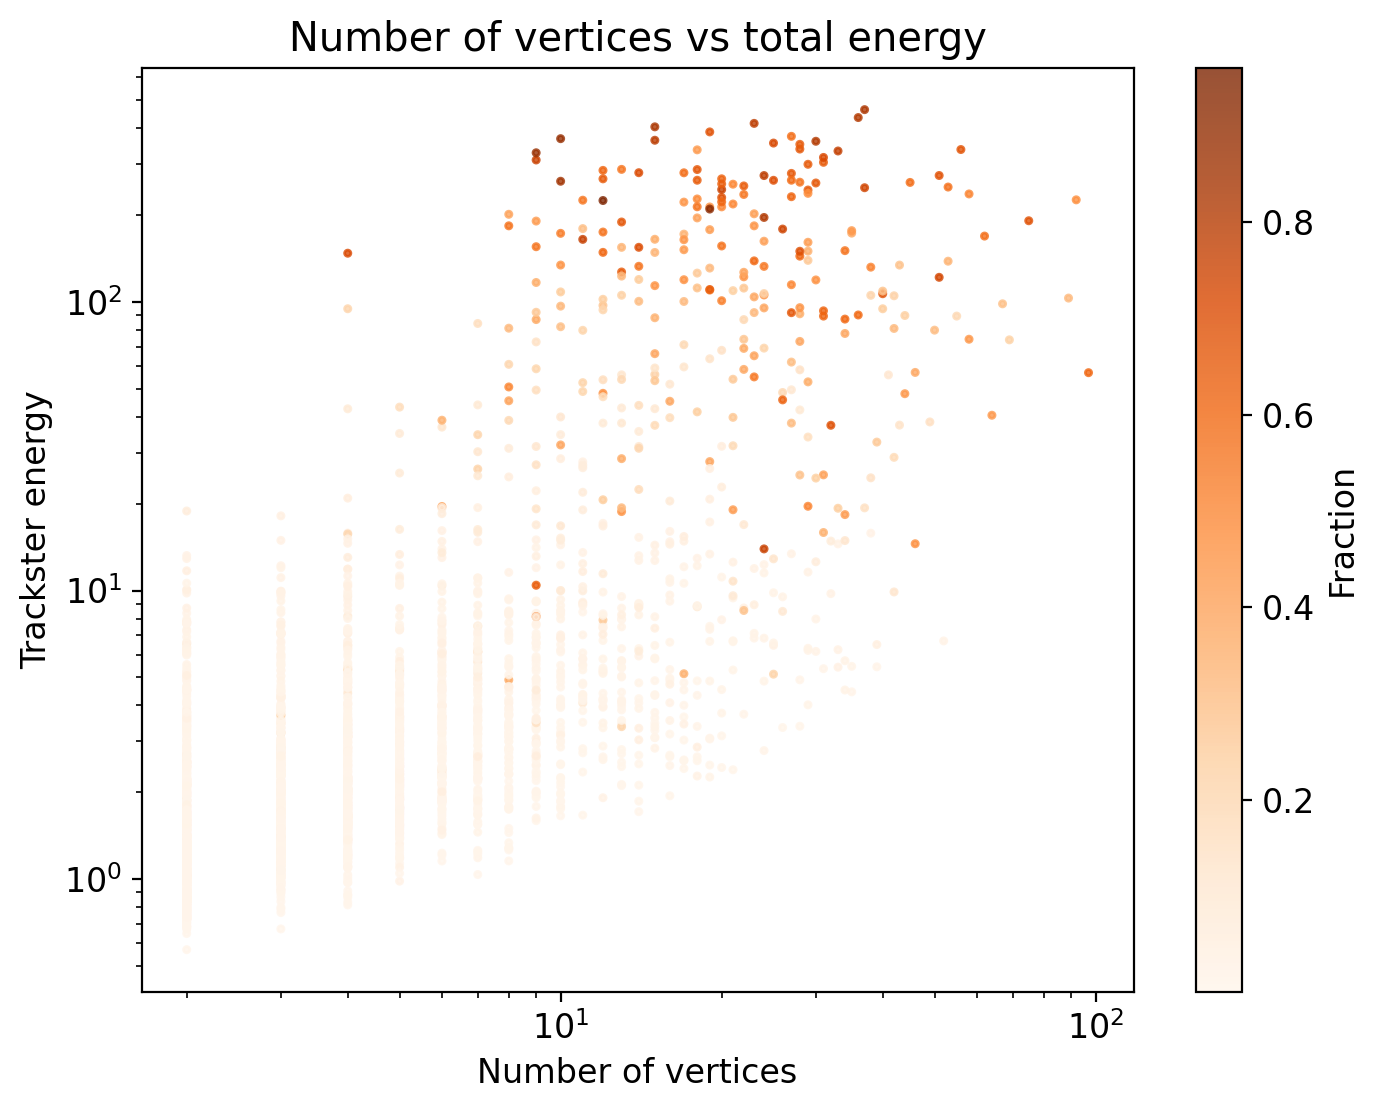

In [5]:
plt.figure(figsize=(8, 6))
plt.title("Number of vertices vs total energy")
plt.xlabel("Number of vertices")
plt.ylabel("Trackster energy")
plt.xscale("log")
plt.yscale("log")

plt.scatter(nvertices, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar = plt.colorbar()
cbar.set_label("Fraction")
plt.show()
# we can use the fraction as a "completeness" score

## Graph based features

In [3]:
import networkx as nx
from itertools import islice
from reco.graphs import create_graph
from reco.plotting import plot_graph_3D

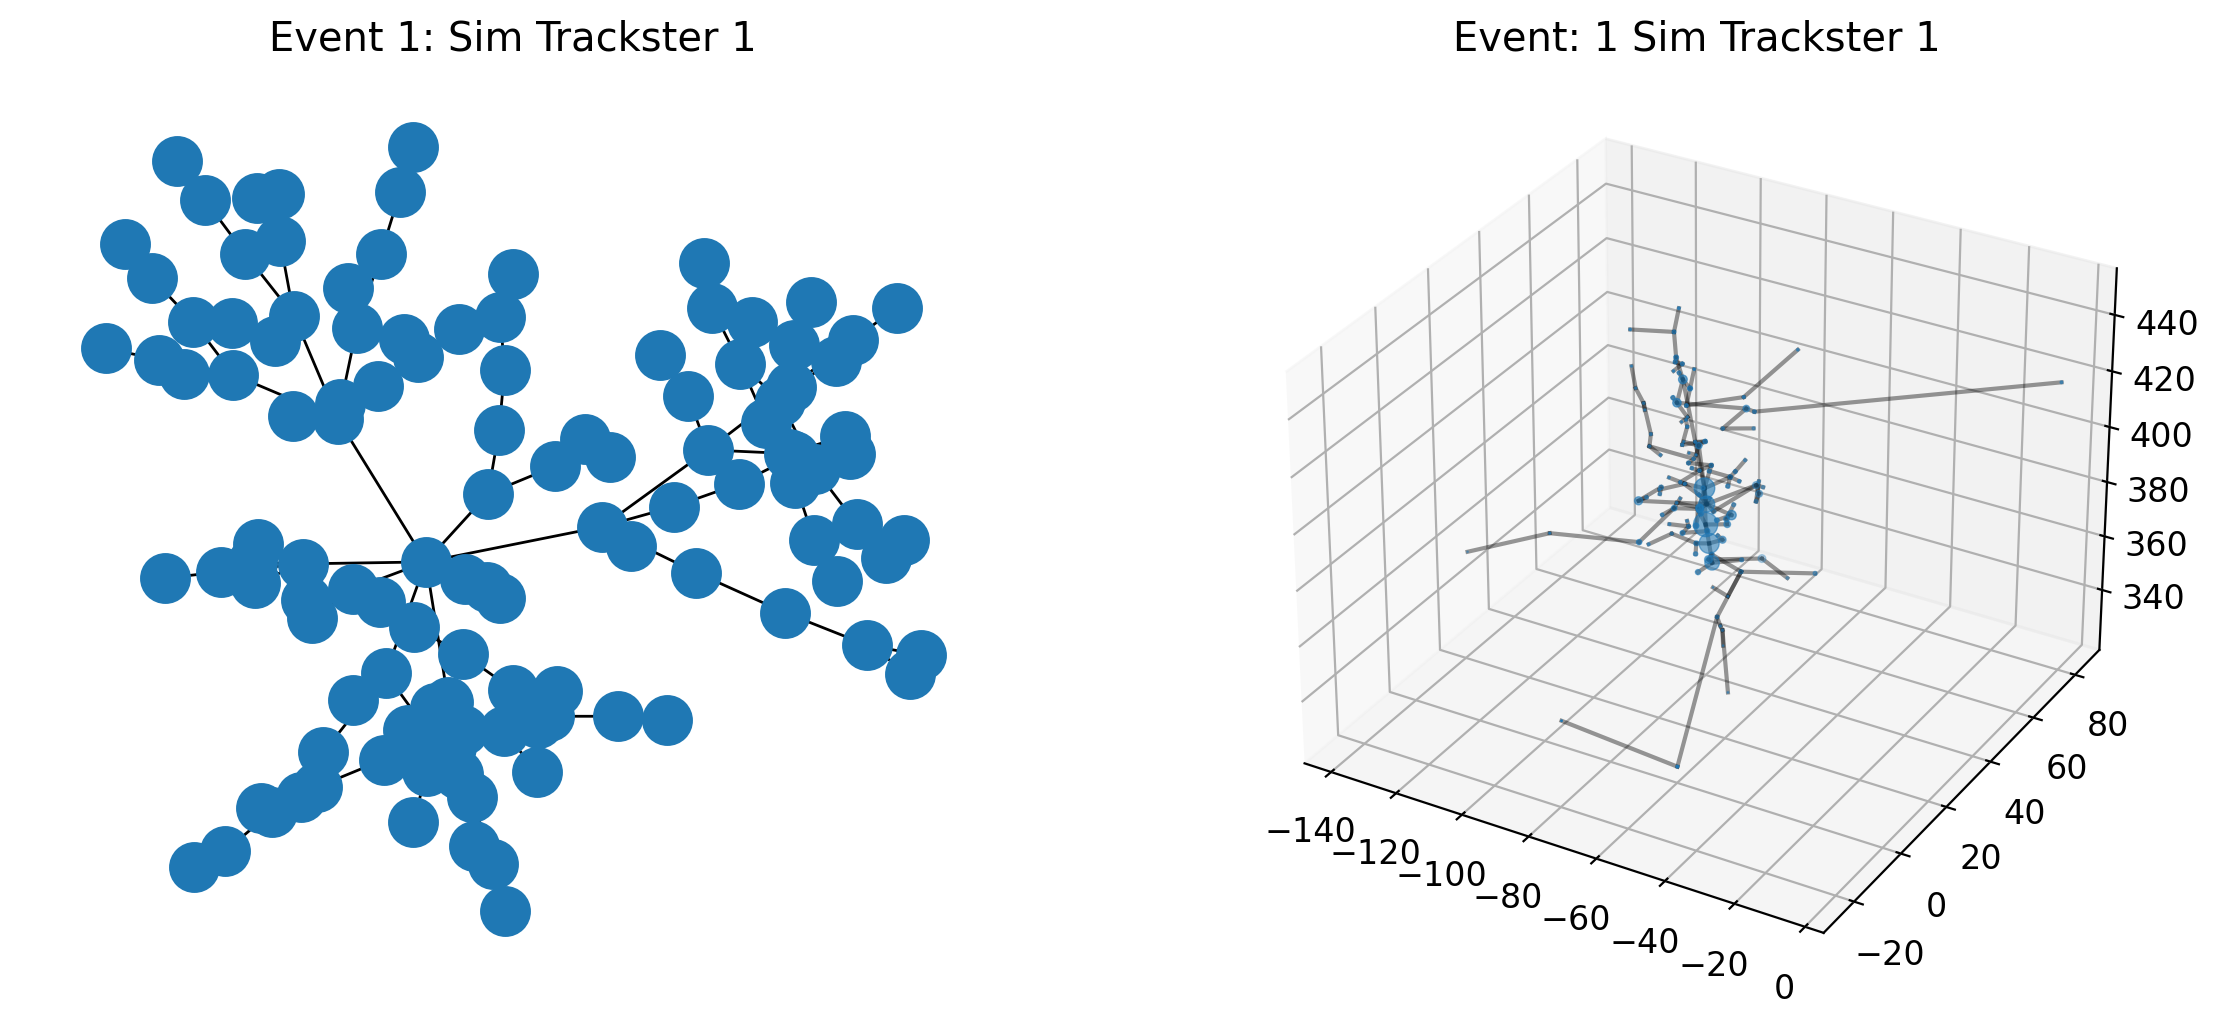

In [7]:
eid = 1
ntx = 1

simgraphs = [create_graph(x, y, z, e, trk_lc_index=i, N=1) for x, y, z, e, i in zip(sx[eid], sy[eid], sz[eid], se[eid], si[eid])]
G = simgraphs[ntx]

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title(f"Event {eid}: Sim Trackster {ntx}")
ax2.set_title(f"Event: {eid} Sim Trackster {ntx}")

nx.draw(G, with_labels=False, ax=ax1)
plot_graph_3D(G, ax=ax2, s=10)

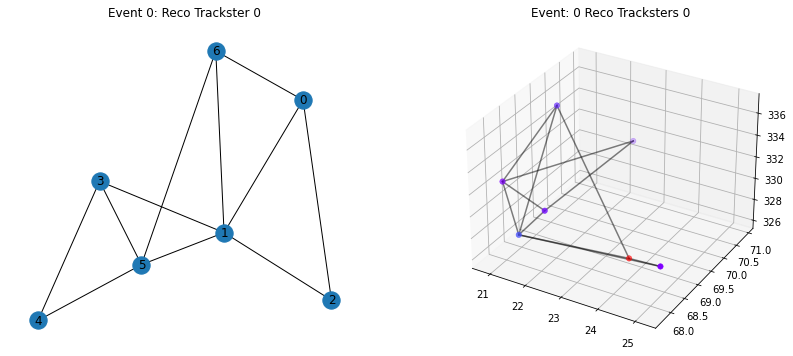

In [68]:
graphs = [(create_graph(x, y, z, e, i, N=2), e) for x, y, z, e, i in zip(cx[eid], cy[eid], cz[eid], ce[eid], ci[eid])]

ntx = 0
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title(f"Event {eid}: Reco Trackster {ntx}")
ax2.set_title(f"Event: {eid} Reco Tracksters {ntx}")
nx.draw(graphs[ntx][0], with_labels=True, ax=ax1)
G, e = graphs[ntx]
plot_graph_3D(G, e, ax=ax2)

## Graph kernels

### Bag of nodes:
- node degrees
- node centralities
- clustering coefficient

### Node based and differential features
Construct graphs by connecting to the nearest-higher.
- Using N=1 (number of nearest highers) to highlight the difference in distances.

- Average difference in energy
    - difference in energy between neighbours
    - assumes well formed tracksters are smoother

- average distance between nodes
    - same but using distance

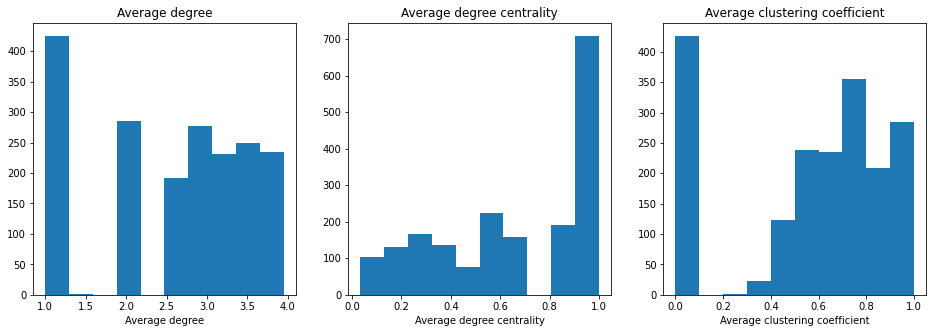

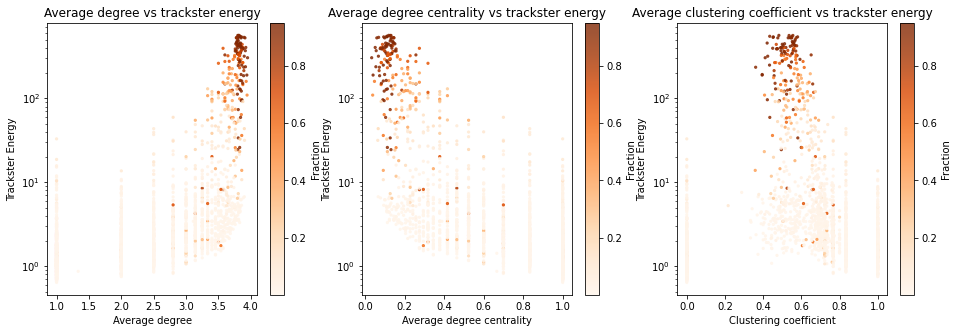

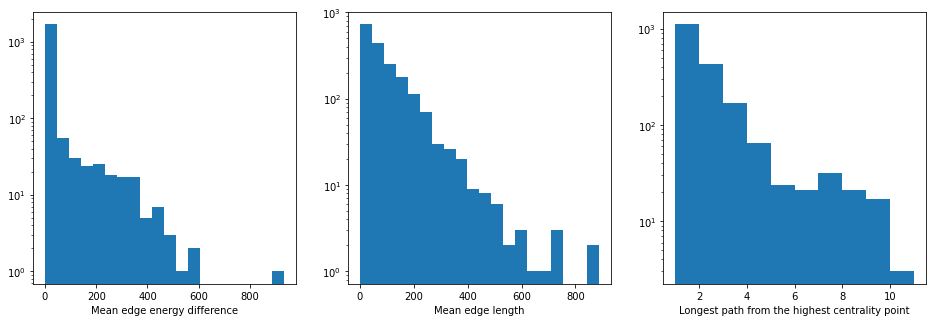

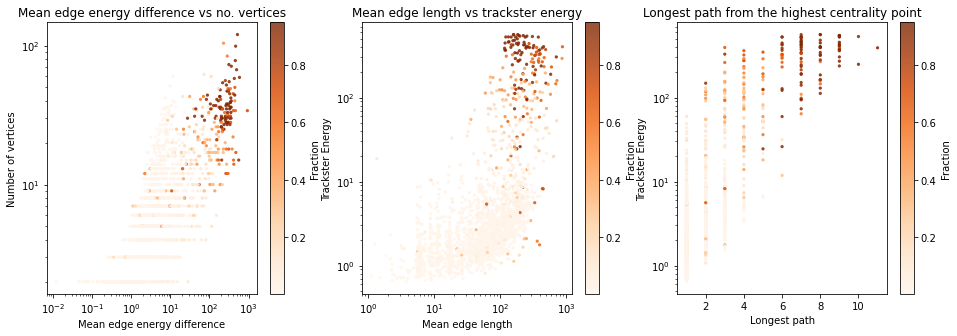

In [85]:
avg_degree = []
avg_centrality = []
avg_clustering = []

longest_path = []
avg_ediff = []
avg_ndist = []

for eid in range(len(cx)):
    _graphs = [create_graph(x, y, z, e, i, N=2) for x, y, z, e, i in zip(cx[eid], cy[eid], cz[eid], ce[eid], ci[eid])]
    for G in _graphs:
        avg_degree.append(np.mean([d for _, d in G.degree()]))
        avg_centrality.append(np.mean(list(nx.degree_centrality(G).values())))
        avg_clustering.append(nx.average_clustering(G))
        longest_path.append(longest_path_from_highest_centrality(G))
        avg_ndist.append(mean_edge_length(G))
        avg_ediff.append(mean_edge_energy_gap(G))

fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title("Average degree")
ax1.set_xlabel("Average degree")
ax1.hist(avg_degree)

ax2.set_title("Average degree centrality")
ax2.set_xlabel("Average degree centrality")
ax2.hist(avg_centrality)

ax3.set_title("Average clustering coefficient")
ax3.set_xlabel("Average clustering coefficient")
ax3.hist(avg_clustering)

plt.show()

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title("Average degree vs trackster energy")
ax1.set_xlabel("Average degree")
ax1.set_ylabel("Trackster Energy")
ax1.set_yscale("log")

sc1 = ax1.scatter(avg_degree, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label("Fraction")


ax2.set_title("Average degree centrality vs trackster energy")
ax2.set_xlabel("Average degree centrality")
ax2.set_ylabel("Trackster Energy")
ax2.set_yscale("log")

sc2 = ax2.scatter(avg_centrality, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar2 = fig.colorbar(sc2, ax=ax2)
cbar2.set_label("Fraction")

ax3.set_title("Average clustering coefficient vs trackster energy")
ax3.set_xlabel("Clustering coefficient")
ax3.set_ylabel("Trackster Energy")
ax3.set_yscale("log")

sc3 = ax3.scatter(avg_clustering, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar3 = fig.colorbar(sc3, ax=ax3)
cbar3.set_label("Fraction")

plt.show()


fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.hist(avg_ediff, bins=20)
ax1.set_yscale("log")
ax1.set_xlabel("Mean edge energy difference")

ax2.set_xlabel("Mean edge length")
ax2.hist(avg_ndist, bins=20)
ax2.set_yscale("log")

ax3.set_xlabel("Longest path from the highest centrality point")
ax3.set_yscale("log")
ax3.hist(longest_path)

plt.show()

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title("Mean edge energy difference vs no. vertices")
ax1.set_xlabel("Mean edge energy difference")
ax1.set_ylabel("Number of vertices")
ax1.set_xscale("log")
ax1.set_yscale("log")

sc1 = ax1.scatter(avg_ediff, nvertices, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label("Fraction")

ax2.set_title("Mean edge length vs trackster energy")
ax2.set_xlabel("Mean edge length")
ax2.set_ylabel("Trackster Energy")
ax2.set_xscale("log")
ax2.set_yscale("log")

sc2 = ax2.scatter(avg_ndist, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar2 = fig.colorbar(sc2, ax=ax2)
cbar2.set_label("Fraction")

ax3.set_title("Longest path from the highest centrality point")
ax3.set_xlabel("Longest path")
ax3.set_ylabel("Trackster Energy")
ax3.set_yscale("log")

sc3 = ax3.scatter(longest_path, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar3 = fig.colorbar(sc3, ax=ax3)
cbar3.set_label("Fraction")

plt.show()

## Combine the features with PCA

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

X = np.array((nvertices, tenergy, longest_path, avg_ediff, avg_ndist, avg_centrality, avg_degree)).T
Xs = scaler.fit_transform(X)

pca = PCA(n_components=2).fit(Xs)
data = pca.transform(Xs)

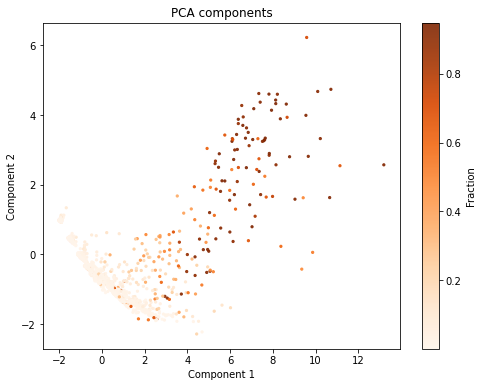

In [91]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.set_title("PCA components")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")

sc1 = ax1.scatter(data[:,0], data[:,1], c=fracs, s=5, cmap="Oranges", alpha=0.9)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label("Fraction")

plt.show()

## Differential features

Features for comparing two different graphs

## Feature decorrelation

Figure out which features make sense